# Ground Zero

## Packages and Datasets

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus' }
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install pydotplus

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

## Overview of Sprint 2
- Understanding of Feature Processes
- Data Merge & Split
- Feature Reduction & Missing Value Treatment
- Outliers
- Feature Engineering
- Baseline Model

## Our Understanding

### Feature Engineering Process

[Source](https://en.wikipedia.org/wiki/Feature_engineering)

The feature engineering process is:
- Brainstorming or testing features;
- Deciding what features to create;
- Creating features;
- Checking how the features work with your model;
- **Improving your features if needed;**
- Go back to brainstorming/creating more features until the work is done.

### Some Terms

[Source](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)

**Feature Extraction and Feature Engineering:** transformation of raw data into features suitable for modeling; 

- Texts(ngrams, word2vec, tf-idf etc)
- Geospatial data(lat, long)
- Date and time(day, month, week, year, rolling based)
- Time series, web, etc
- Dimensional Reduction Techniques (PCA, SVD, Eigen-Faces etc)
- Clustering (DBSCAN etc)
- And others.

---

**Feature / Data Transformation:** transformation of data to improve the accuracy of the algorithm;
- Normalization and changing distribution(Scaling)
- Interactions
- Handling missing Values
- Handling outliers
- Handling time-date / mixed variables
- Encoding categorical features
- Variable types 
- And others.

---

**Feature Selection:** removing unnecessary features.

- Statistical approaches
- Selection by modeling
- Grid search
- Cross Validation
- And others

---

For the purpose of workflow, we will split **Feature Selection** into; 
- **feature reduction** to remove unnecessary features, 
- and **feature selection** to select features by their importance scores through ML/statistical techniques.

# Data Merge & Split

## Merging datasets

The goal is to successfully merge all datasets by increasing crash records as little as possible.

In [5]:
print("Here is the initial shape of the three datasets:")
print("Crashes", crashes.shape)
print("Vehicles", vehicles.shape)
print("People", people.shape)

Here is the initial shape of the three datasets:
Crashes (33408, 49)
Vehicles (75673, 72)
People (82049, 30)


**Data Merge Strategy**

- Filter out passengers from **`people`**, and left-join it to **`vehicles`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`, `VEHICLE_ID`.

- Then inner-join this dataset to **`crashes`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`.

---

**Reasoning**

- `people` has **many-to-one relationship** with `vehicles` but a pedestrian in `vehicles` has **one-to-one** with `people`,

- Passengers don't have <u>a trajectory separate from the unit</u> they belong to and they don't contribute to accidents with their existence but they are involved if they got harmed through `injuries` features,

- This method increases `crashes` records **only per active parties involved**.

In [6]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
# non_passengers = people[people.PERSON_ID.str.contains('^O')]

In [7]:
# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(#non_passengers, 
                                      people, how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])
vehicles_with_people.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,228894,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,1,DRIVER,NaN,224185,NaN,DODGE,CHARGER,IL,2012,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,1,NaN,PRIVATE TOW,UNKNOWN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228894,DRIVER,NaN,KANKAKKE,IL,60901,M,18,IL,D,SAFETY BELT USED,"DEPLOYED, FRONT",NONE,NONINCAPACITATING INJURY,NaN,NaN,NaN,UNKNOWN,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,228895,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,2,PARKED,NaN,224187,NaN,GENERAL MOTORS CORP.,YUKON,IL,2003,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,Y,NaN,0,NaN,PRIVATE TOW,UNKNOWN,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228896,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,3,PARKED,NaN,224191,NaN,SATURN,UNKNOWN,IL,2000,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228905,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,1,DRIVER,NaN,224199,NaN,FORD,WINDSTAR,IL,2007,NONE,VAN/MINI-VAN,PERSONAL,E,STRAIGHT AHEAD,Y,NaN,1,NaN,NaN,NaN,NaN,Y,Y,Y,Y,NaN,N,N,N,NaN,NaN,Y,NaN,NaN,TOTAL (ALL AREAS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228905,DRIVER,NaN,CHICAGO,IL,60632,M,43,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER LANE CHANGE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,228906,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,2,DRIVERLESS,NaN,224203,NaN,CHEVROLET,CRUZE,IL,2012,NONE,PASSENGER,NOT IN USE,UNKNOWN,PARKED,Y,NaN,0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,Y,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Shape of vehicles with people", vehicles_with_people.shape)

Shape of vehicles with people (92227, 98)


In [9]:
merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (83489, 144)


**Inspection 1**

In [10]:
merged_data.groupby('CRASH_RECORD_ID').head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

**Inspection 2**

In [127]:
merged_data.groupby(['STREET_NAME']).size().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

,STREET_NAME,count
1078,WESTERN AVE,2352
928,PULASKI RD,2095
350,CICERO AVE,1964
235,ASHLAND AVE,1937
528,HALSTED ST,1593
613,KEDZIE AVE,1367
782,MICHIGAN AVE,1042
840,NORTH AVE,987
1007,STATE ST,977
310,CALIFORNIA AVE,971


In [11]:
print("Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.")
merged_data[merged_data.RD_NO=='JC301403'] #Wrong joins could result in 6 rows

Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

## Splitting the data

In [12]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

In [13]:
print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (66791, 144)
Test shape (16698, 144)


**Write datasets as csv**

In [14]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

## Detailed look at all features

In [15]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66791 entries, 904 to 15795
Columns: 144 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](2), object(142)
memory usage: 73.9+ MB


| **Feature** | **Description** | **Decision to drop** |
|:-----|:----:|----:|
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| CRASH_DATE_EST_I | Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash) | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | NO |
| POSTED_SPEED_LIMIT | Posted speed limit, as determined by reporting officer | NO |
| TRAFFIC_CONTROL_DEVICE | Traffic control device present at crash location, as determined by reporting officer | NO |
| DEVICE_CONDITION | Condition of traffic control device, as determined by reporting officer | NO |
| WEATHER_CONDITION | Weather condition at time of crash, as determined by reporting officer | NO |
| LIGHTING_CONDITION | Light condition at time of crash, as determined by reporting officer | NO |
| FIRST_CRASH_TYPE | Type of first collision in crash | NO |
| TRAFFICWAY_TYPE | Trafficway type, as determined by reporting officer | NO |
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | NO |
| ALIGNMENT | Street alignment at crash location, as determined by reporting officer | NO |
| ROADWAY_SURFACE_COND | Road surface condition, as determined by reporting officer | NO |
| ROAD_DEFECT | Road defects, as determined by reporting officer | NO |
| REPORT_TYPE | Administrative report type (at scene, at desk, amended) | YES |
| CRASH_TYPE | A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away | NO |
| INTERSECTION_RELATED_I |A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection. | NO |
| NOT_RIGHT_OF_WAY_I | Whether the crash begun or first contact was made outside of the public right-of-way. | NO |
| HIT_AND_RUN_I | Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid | NO |
| DAMAGE | A field observation of estimated damage. | NO |
| DATE_POLICE_NOTIFIED | Calendar date on which police were notified of the crash | YES |
| PRIM_CONTRIBUTORY_CAUSE | The factor which was most significant in causing the crash, as determined by officer judgment | NO |
| SEC_CONTRIBUTORY_CAUSE | The factor which was second most significant in causing the crash, as determined by officer judgment | NO |
| STREET_NO | Street address number of crash location, as determined by reporting officer | NO |
| STREET_DIRECTION | Street address direction (N,E,S,W) of crash location, as determined by reporting officer | NO |
| STREET_NAME | Street address name of crash location, as determined by reporting officer | NO |
| BEAT_OF_OCCURRENCE | Chicago Police Department Beat ID | YES |
| PHOTOS_TAKEN_I | Whether the Chicago Police Department took photos at the location of the crash | YES |
| STATEMENTS_TAKEN_I | Whether statements were taken from unit(s) involved in crash | YES |
| DOORING_I | Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash | NO |
| WORK_ZONE_I | Whether the crash occurred in an active work zone | NO |
| WORK_ZONE_TYPE | The type of work zone, if any | YES |
| WORKERS_PRESENT_I | Whether construction workers were present in an active work zone at crash location | YES |
| NUM_UNITS | Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory. | NO |
| MOST_SEVERE_INJURY | Most severe injury sustained by any person involved in the crash | NO |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | NO |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | NO |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | NO |
| INJURIES_NON_INCAPACITATING | Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations. | NO |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | NO |
| INJURIES_NO_INDICATION | Total persons sustaining no injuries in the crash as determined by the reporting officer | YES |
| INJURIES_UNKNOWN | Total persons for whom injuries sustained, if any, are unknown | YES |
| CRASH_HOUR | The hour of the day component of CRASH_DATE. | NO |
| CRASH_DAY_OF_WEEK | The day of the week component of CRASH_DATE. Sunday=1 | YES |
| CRASH_MONTH | The month component of CRASH_DATE. | YES |
| LATITUDE | The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LONGITUDE | The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | YES || PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | NO |
| PERSON_TYPE | Type of roadway user involved in crash | NO |
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| VEHICLE_ID | The corresponding CRASH_UNIT_ID from the Vehicles dataset. | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | YES |
| SEAT_NO | Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 3 = front passenger, 4 = second row left, 5 = second row center, 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right | YES |
| CITY | City of residence of person involved in crash | NO |
| STATE | State of residence of person involved in crash | YES |
| ZIPCODE | ZIP Code of residence of person involved in crash | YES |
| SEX | Gender of person involved in crash, as determined by reporting officer | NO |
| AGE | Age of person involved in crash | NO |
| DRIVERS_LICENSE_STATE | State issuing driver's license of person involved in crash | YES |
| DRIVERS_LICENSE_CLASS| Class of driver's license of person involved in crash | YES |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | NO |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | NO |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | NO |
| INJURY_CLASSIFICATION | Severity of injury person sustained in the crash | YES |
| HOSPITAL | Hospital to which person injured in the crash was taken | YES |
| EMS_AGENCY | EMS agency who transported person injured in crash to the hospital | YES |
| EMS_RUN_NO | EMS agency run number | YES |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | NO |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash | NO |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | NO |
| PEDPEDAL_ACTION | Action of pedestrian or cyclist at the time of crash | NO |
| PEDPEDAL_VISIBILITY | Visibility of pedestrian of cyclist safety equipment in use at time of crash | NO |
| PEDPEDAL_LOCATION | Location of pedestrian or cyclist at the time of crash | YES |
| BAC_RESULT | Status of blood alcohol concentration testing for driver or other person involved in crash | YES |
| BAC_RESULT VALUE | Driver’s blood alcohol concentration test result | NO |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer | NO |
|CRASH_UNIT_ID | A unique identifier for each vehicle record | YES | 
|CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and People datasets. This number also serves as a unique ID in the Crashes dataset | NO | 
|RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes | Yes | 
|CRASH_DATE| Date and time of crash as entered by the reporting officer | No | 
|UNIT_NO| A unique ID for each unit within a specific crash report | Yes | 
|UNIT_TYPE| Type of unit | Yes | 
|NUM_PASSENGERS| Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset | No | 
|VEHICLE_ID| No definition | Yes | 
|CMRC_VEH_I| No definition | Yes | 
|MAKE| The make (brand) of the vehicle, if relevant | YES | 
|MODEL| The model of the vehicle, if relevant| NO | 
|LIC_PLATE_STATE| The state issuing the license plate of the vehicle, if relevant | No | 
|VEHICLE_YEAR| The model year of the vehicle, if relevant | No | 
|VEHICLE_DEFECT| No definition | No | 
|VEHICLE_TYPE| The type of vehicle, if relevant | No | 
|TRAVEL_DIRECTION| The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | No | 
|MANEUVER| The action the unit was taking prior to the crash, as determined by the reporting officer | NO | 
|TOWED_I| Indicator of whether the vehicle was towed | Yes | 
|FIRE_I| No definition | Yes | 
|OCCUPANT_COUNT| The number of people in the unit, as determined by the reporting officer | No | 
|EXCEED_SPEED_LIMIT_I| Indicator of whether the unit was speeding, as determined by the reporting officer | No | 
|TOWED_BY| No definition | Yes | 
|TOWED_TO| No definition | Yes | 
|AREA_00_I:AREA_99_I| No definition | Yes | 
|FIRST_CONTACT_POINT| No definition | No | 
|CMV_ID:HAZMAT_CLASS| No definition | Yes |


**Features to be excluded are**
- `RD_NO`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_TYPE`
- `NOT_RIGHT_OF_WAY_I`
- `DATE_POLICE_NOTIFIED`
- `STREET_DIRECTION`
- `ALIGNMENT`
- `BEAT_OF_OCCURRENCE`
- `PHOTOS_TAKEN_I`
- `STATEMENTS_TAKEN_I`
- `DOORING_I`
- `WORK_ZONE_I`
- `WORK_ZONE_TYPE`
- `WORKERS_PRESENT_I`
- `MOST_SEVERE_INJURY`
- `INJURIES_NO_INDICATION`
- `INJURIES_UNKNOWN`
- `CRASH_DAY_OF_WEEK`
- `CRASH_MONTH`
- `LATITUDE`
- `LONGITUDE`
- `RD_NO`
- `VEHICLE_ID`
- `CRASH_DATE`
- `SEAT_NO`
- `CITY`
- `STATE`
- `ZIPCODE`
- `DRIVERS_LICENSE_STATE`
- `DRIVERS_LICENSE_CLASS`
- `INJURY_CLASSIFICATION`
- `HOSPITAL`
- `EMS_AGENCY`
- `EMS_RUN_NO`
- `PEDPEDAL_ACTION`	
- `PEDPEDAL_VISIBILITY`
- `PEDPEDAL_LOCATION`
- `BAC_RESULT`
- `BAC_RESULT VALUE`
- `CRASH_UNIT_ID`
- `RD_NO`
- `UNIT_NO`
- `UNIT_TYPE`
- `VEHICLE_ID`
- `CMRC_VEH_I`
- `MAKE`
- `MODEL`
- `TOWED_I`
- `FIRE_I`
- `TOWED_BY`
- `TOWED_TO`
- `AREA_00_I`
- `AREA_01_I`
- `AREA_02_I`
- `AREA_03_I`
- `AREA_04_I`
- `AREA_05_I`
- `AREA_06_I`
- `AREA_07_I`
- `AREA_08_I`
- `AREA_09_I`
- `AREA_10_I`
- `AREA_11_I`
- `AREA_12_I`
- `AREA_99_I`
- `CMV_ID:HAZMAT_CLASS`




**Due to the reasons**
- Redundant information
- Non value information (at least for our baseline model)

Do not drop "SEAT_NO"

In [16]:
# Drop the features that are not needed
# Do not drop "SEAT_NO", 
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "DATE_POLICE_NOTIFIED","BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "WORK_ZONE_TYPE", "WORKERS_PRESENT_I","INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", "CRASH_RECORD_ID",
                      "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID",
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION","DAMAGE","CRASH_TYPE","MODEL",
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66791 entries, 904 to 15795
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               66791 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       66791 non-null  object        
 2   TRAFFIC_CONTROL_DEVICE   66791 non-null  object        
 3   DEVICE_CONDITION         66791 non-null  object        
 4   WEATHER_CONDITION        66791 non-null  object        
 5   LIGHTING_CONDITION       66791 non-null  object        
 6   FIRST_CRASH_TYPE         66791 non-null  object        
 7   TRAFFICWAY_TYPE          66791 non-null  object        
 8   LANE_CNT                 22188 non-null  object        
 9   ALIGNMENT                66791 non-null  object        
 10  ROADWAY_SURFACE_COND     66791 non-null  object        
 11  ROAD_DEFECT              66791 non-null  object        
 12  INTERSECTION_RELATED_I   17201

In [17]:
train['SEAT_NO'].value_counts()
# Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 
# 3 = front passenger, 4 = second row left, 5 = second row center, 
# 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 
# 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right

3     5983
6     2179
4     1728
5      626
1      548
2      519
12     335
10     286
7      261
11     130
8       18
Name: SEAT_NO, dtype: int64

In [18]:
#train["PERSON_ID"].value_counts()

TRAFFIC_CONTROL_DEVICE- UNKNOWN, OTHER
DEVICE_CONDITION - UNKNOWN, OTHER
WEATHER_CONDITION - UNKNOWN, OTHER
LIGHTING_CONDITION - UNKNOWN
TRAFFICWAY_TYPE - UNKNOWN, OTHER
ROADWAY_SURFACE_COND - UNKNOWN, OTHER
ROAD_DEFECT - UNKNOWN, OTHER
PRIM_CONTRIBUTORY_CAUSE- UNABLE TO DETERMINE
SEC_CONTRIBUTORY_CAUSE - UNABLE TO DETERMINE
MODEL - UNKNOWN
VEHICLE_DEFECT - UNKNOWN, OTHER
VEHICLE_TYPE - UNKNOWN/NA
TRAVEL_DIRECTION - UNKNOWN
MANEUVER - UNKNOWN/NA
SEX - X
SAFETY_EQUIPMENT - USAGE UNKNOWN
AIRBAG_DEPLOYED - DEPLOYMENT UNKNOWN
EJECTION - UNKNOWN
DRIVER_ACTION - UNKNOWN
DRIVER_VISION - UNKNOWN
PHYSICAL_CONDITION - UNKNOWN
PEDPEDAL_ACTION - UNKNOWN/NA 

In [19]:
train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan

In [20]:
train.isnull().sum()

CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE      1871
DEVICE_CONDITION            3451
WEATHER_CONDITION           2353
LIGHTING_CONDITION          1948
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE              577
LANE_CNT                   44603
ALIGNMENT                      0
ROADWAY_SURFACE_COND        3910
ROAD_DEFECT                 9248
INTERSECTION_RELATED_I     49590
NOT_RIGHT_OF_WAY_I         64038
HIT_AND_RUN_I              48013
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                  66596
WORK_ZONE_I                66420
NUM_UNITS                      0
MOST_SEVERE_INJURY           113
INJURIES_TOTAL               112
CRASH_HOUR                     0
LATITUDE                     365
LONGITUDE                    365
NUM_PASSENGERS             46336
LIC_PLATE_STATE             6077
VEHICLE_YEAR               10735
VEHICLE_DEFECT             27497
VEHICLE_TY

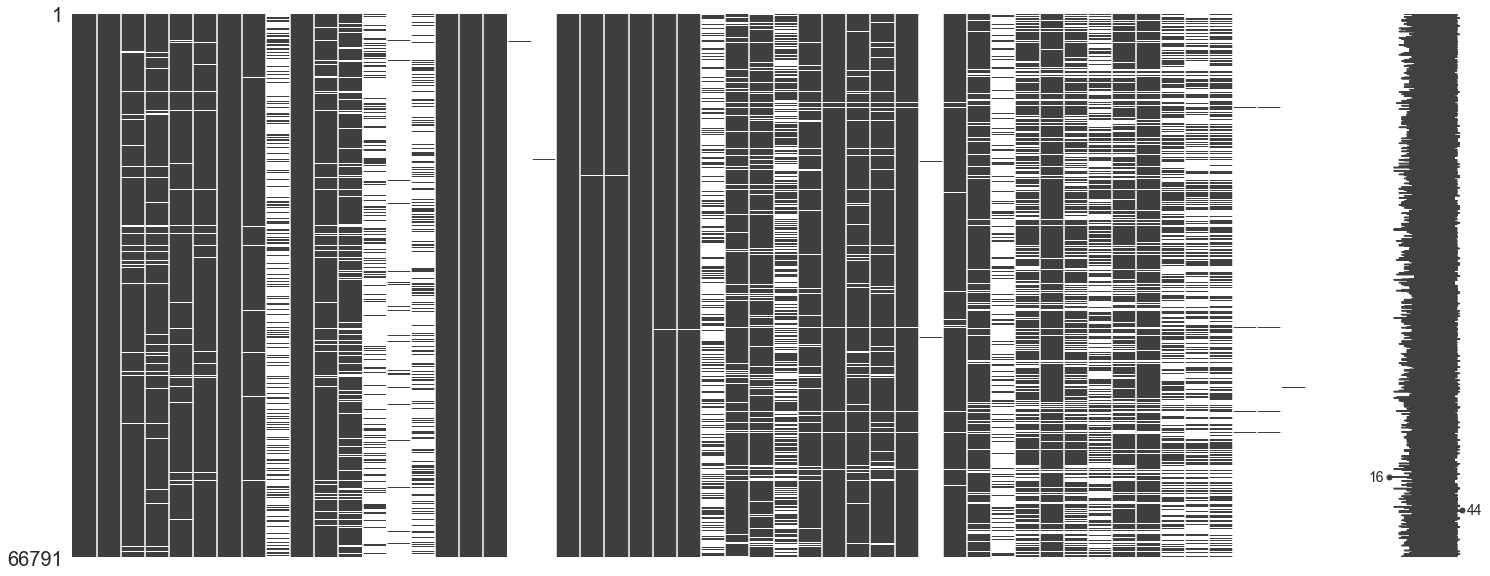

In [21]:
msno.matrix(train)

In [22]:
train.groupby(['PERSON_TYPE']).size()

PERSON_TYPE
BICYCLE                  416
DRIVER                 45803
NON-CONTACT VEHICLE       13
NON-MOTOR VEHICLE         57
PASSENGER              12613
PEDESTRIAN               855
dtype: int64

## Missing value overview on train data

In [23]:
print('\033[1m', 'All 50 columns', '\033[0m')
print('\033[1m', 'These', sum(train.isnull().mean().round(5) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(train.columns[train.isnull().mean().round(5) > 0.5].tolist())
print('')
raw_null_above50 = train[train.columns[train.isnull().mean().round(5) > 0.5].tolist()]
print(raw_null_above50.isnull().mean().round(5))
print('')
# Subset the data to include the columns only with nulls in the output
train_with_null = train[train.columns[train.isnull().any()].tolist()]
print('\033[1m', 'These', len(train_with_null.columns),
      'columns have any missing values', '\033[0m')
train_with_null.isnull().mean().round(5)

 All 50 columns 
 These 16 columns have > 50% missing values 
['LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DOORING_I', 'WORK_ZONE_I', 'NUM_PASSENGERS', 'EXCEED_SPEED_LIMIT_I', 'SEAT_NO', 'SAFETY_EQUIPMENT', 'DRIVER_VISION', 'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

LANE_CNT                  0.66780
INTERSECTION_RELATED_I    0.74247
NOT_RIGHT_OF_WAY_I        0.95878
HIT_AND_RUN_I             0.71885
DOORING_I                 0.99708
WORK_ZONE_I               0.99445
NUM_PASSENGERS            0.69375
EXCEED_SPEED_LIMIT_I      0.99654
SEAT_NO                   0.81116
SAFETY_EQUIPMENT          0.50770
DRIVER_VISION             0.59510
PHYSICAL_CONDITION        0.50580
PEDPEDAL_ACTION           0.98301
PEDPEDAL_VISIBILITY       0.98072
BAC_RESULT VALUE          0.99844
CELL_PHONE_USE            0.99922
dtype: float64

 These 43 columns have any missing values 


TRAFFIC_CONTROL_DEVICE    0.02801
DEVICE_CONDITION          0.05167
WEATHER_CONDITION         0.03523
LIGHTING_CONDITION        0.02917
TRAFFICWAY_TYPE           0.00864
LANE_CNT                  0.66780
ROADWAY_SURFACE_COND      0.05854
ROAD_DEFECT               0.13846
INTERSECTION_RELATED_I    0.74247
NOT_RIGHT_OF_WAY_I        0.95878
HIT_AND_RUN_I             0.71885
DOORING_I                 0.99708
WORK_ZONE_I               0.99445
MOST_SEVERE_INJURY        0.00169
INJURIES_TOTAL            0.00168
LATITUDE                  0.00546
LONGITUDE                 0.00546
NUM_PASSENGERS            0.69375
LIC_PLATE_STATE           0.09099
VEHICLE_YEAR              0.16073
VEHICLE_DEFECT            0.41169
VEHICLE_TYPE              0.09805
VEHICLE_USE               0.02180
TRAVEL_DIRECTION          0.08257
MANEUVER                  0.08639
OCCUPANT_CNT              0.02180
EXCEED_SPEED_LIMIT_I      0.99654
FIRST_CONTACT_POINT       0.02960
PERSON_TYPE               0.10531
SEAT_NO       

In [24]:
train["PEDPEDAL_VISIBILITY"].value_counts()

NO CONTRASTING CLOTHING    1028
CONTRASTING CLOTHING        168
OTHER LIGHT SOURCE USED      63
REFLECTIVE MATERIAL          29
Name: PEDPEDAL_VISIBILITY, dtype: int64

In [25]:
# replacing TRAFFIC_CONTROL_DEVICE with No Controls 
# replacing DEVICE_CONDITION with No Controls 
# replace SEAT_NO with 0

train.fillna({
    'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
    'DEVICE_CONDITION': 'NO CONTROLS',
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'ROADWAY_SURFACE_COND': 'NO DEFECTS',
    'ROAD_DEFECT': 'CLEAR',
    'INTERSECTION_RELATED_I': 'N',
    
    'NOT_RIGHT_OF_WAY_I': 'N',
    'HIT_AND_RUN_I': 'N',
    'DOORING_I': 'N',
    'WORK_ZONE_I': 'N',
    'NUM_PASSENGERS': 0,
    'LIC_PLATE_STATE': 'IL',
    'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
    'VEHICLE_TYPE': 'OTHER',
    
    'VEHICLE_USE': 'OTHER',
    'TRAVEL_DIRECTION': 'N',
    'MANEUVER': 'OTHER',
    'OCCUPANT_CNT': 0,
    'EXCEED_SPEED_LIMIT_I': 'N',
    'FIRST_CONTACT_POINT': 'OTHER',
    'PERSON_TYPE': 'UNABLE TO DETERMINE',
    'CITY': 'OTHER',
    
    'SEX': 'UNABLE TO DETERMINE',
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
    'EJECTION': 'UNABLE TO DETERMINE',
    'DRIVER_ACTION': 'OTHER',
    'DRIVER_VISION': 'OTHER',
    'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',
    
    'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
    'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
    'BAC_RESULT VALUE': 0,
    'SEAT_NO':0
}, inplace=True)

In [26]:
train.isnull().sum()

CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
LANE_CNT                   44603
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
INTERSECTION_RELATED_I         0
NOT_RIGHT_OF_WAY_I             0
HIT_AND_RUN_I                  0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                      0
WORK_ZONE_I                    0
NUM_UNITS                      0
MOST_SEVERE_INJURY           113
INJURIES_TOTAL               112
CRASH_HOUR                     0
LATITUDE                     365
LONGITUDE                    365
NUM_PASSENGERS                 0
LIC_PLATE_STATE                0
VEHICLE_YEAR               10735
VEHICLE_DEFECT                 0
VEHICLE_TY

| **Feature** | **Description** | **Decision on NA** |
|:----|:----|:-----|
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | Replace with mode = 2 |
| INTERSECTION_RELATED_I | A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection.Y&N | Replace with "N" |
| HIT_AND_RUN_I |  Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid Y&N | Replace with "N" |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | Replace with "0" |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | Replace with "0" |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | Replace with "0" |
| INJURIES_NON_INCAPACITATING | Total persons sustaining no injuries in the crash as determined by the reporting officer | Replace with "0" |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | Replace with "0" |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | DROP the row |
| NUM_PASSENGERS | Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset. | DROP the column |
| LIC_PLATE_STATE | The state issuing the license plate of the vehicle, if relevant | Replace with "IL" |
| VEHICLE_YEAR | The model year of the vehicle, if relevant | DROP the row |
| VEHICLE_DEFECT | no definition | Replace with "UNKNOWN" |
| VEHICLE_TYPE | The type of vehicle, if relevant | Replace with "UNKNOWN/NA" |
| VEHICLE_USE | The normal use of the vehicle, if relevant | Replace with "UNKNOWN/NA" |
| TRAVEL_DIRECTION | The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN" |
| MANEUVER | The action the unit was taking prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN/NA" |
| OCCUPANT_CNT |The number of people in the unit, as determined by the reporting officer | DROP the row |
| EXCEED_SPEED_LIMIT_I | Indicator of whether the unit was speeding, as determined by the reporting officer | DROP Column |
| FIRST_CONTACT_POINT | No definition | Replace with "UNKNOWN" |
| PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | DROP the row |
| PERSON_TYPE | Type of roadway user involved in crash | DROP the row |
| SEX | Gender of person involved in crash, as determined by reporting officer | Replace with "X" |
| AGE | Age of person involved in crash | Replace with mean |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | Replace with "USAGE UNKNOWN" |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | REplace with "DEPLOYMENT UNKNOWN" |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | Replace with "UNKNOWN" |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | Replace with "UNKNOWN" |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash| Replace with "UNKNOWN" |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | Replace with "UNKNOWN" |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer Y&N | DROP Column |

*Replace columns with 0*
- 1. “INJURIES_TOTAL”: 97 missing data, replace with 0
- 2. “INJURIES_FATAL”: 97 missing data, replace with 0
- 3. “INJURIES_INCAPACITATING”: 97 missing data, replace with 0
- 4. “INJURIES_NON_INCAPACITATING”: 97 missing data, replace with 0
- 5. “INJURIES_REPORTED_NOT_EVIDENT”: 97 missing data, replace with 0

*Replace with meaningful input*
- 1. “LIC_PLATE_STATE”: 4,817 missing data, replace with "IL"
- 2. "SEX": 6406 missing data, replace with "X"
- 3. "SAFETY_EQUIPMENT" : 6,553 missing data, replace with "USAGE UNKNOWN"
- 4. "AIRBAG_DEPLOYED" : 7,470 missing data, replace with "DEPLOYMENT UNKNOWN"

*Replace with frequency (mode):*
- 1. “LANE_CNT”: 30,763 missing data. Replace them with mode “2”

*Replace with "N" to keep it binary:*
- 1. “INTERSECTION_RELATED_I”: 34,718 missing data
- 2. “HIT_AND_RUN_I”: 32,242 missing data


*Replace with "UNKNOWN":*
- 1. "VEHICLE_DEFECT": 1,225 missing data
- 2. "TRAVEL_DIRECTION" : 1,225 missing data
- 3. "FIRST_CONTACT_POINT" : 1,570 missing data
- 4. "EJECTION" : 7,138 missing data
- 5. "DRIVER_ACTION" : 6,511 missing data
- 6. "DRIVER_VISION" : 6,518 missing data
- 7. "PHYSICAL_CONDITION" : 6,466 missing data

*Replace with "UNKNOWN/NA":*
- 1. “VEHICLE_TYPE”: 1,225 missing data
- 2. "VEHICLE_USE": 1,225 missing data
- 3. "MANEUVER" : 1,225 missing data

*Replace with Mean:*
- 1. "AGE" : 16,073 missing data

*Replace with mode/median:*
- 1. "VEHICLE_YEAR" : 8,329 missing data 
- 2. "OCCUPANT_CNT" : 1,225 missing data

*Drop the missing row:*
- 1. "LOCATION" : 249 missing data
- 2. "PERSON_TYPE" : 6.371 missing data
- 3. "MOST_SEVERE_INJURY" : 115 missing data (target feature)

*Drop the column:*
- 1. "NUM_PASSENGERS" : 38,788 missing data
- 2. "CELL_PHONE_USE" : 45,848 missing data
- 3. "EXCEED_SPEED_LIMIT_I" : 45,757 missing data
- 4. "PERSON_ID" : 6,371 missing data (not useful)

### Adjust in dataset

#### Replace by 0

#### Replace with meaningful input

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [27]:
train['LANE_CNT'].fillna("2",inplace=True)

In [28]:
print("Total NAs in LANE_CNT")
train['LANE_CNT'].isnull().sum()

Total NAs in LANE_CNT


0

#### Replace by "N" to keep it binary

#### Replace with "OTHER" or "UNKNOWN" or  "UNKNOWN/NA":

In [29]:
print("Total NAs in MANEUVER")
train['MANEUVER'].isnull().sum()

Total NAs in MANEUVER


0

#### Replace with median

In [30]:
train["AGE"] = pd.to_numeric(train["AGE"])
train['AGE'].fillna((train['AGE'].median()), inplace=True)
print("TOTAL NAs in AGE")
train['AGE'].isnull().sum()

TOTAL NAs in AGE


0

In [31]:
train.isnull().sum()

CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
LANE_CNT                       0
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
INTERSECTION_RELATED_I         0
NOT_RIGHT_OF_WAY_I             0
HIT_AND_RUN_I                  0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                      0
WORK_ZONE_I                    0
NUM_UNITS                      0
MOST_SEVERE_INJURY           113
INJURIES_TOTAL               112
CRASH_HOUR                     0
LATITUDE                     365
LONGITUDE                    365
NUM_PASSENGERS                 0
LIC_PLATE_STATE                0
VEHICLE_YEAR               10735
VEHICLE_DEFECT                 0
VEHICLE_TY

#### Replace with mode/median

In [32]:
train['VEHICLE_YEAR'].fillna(train['VEHICLE_YEAR'].mode()[0], inplace=True)

train["OCCUPANT_CNT"] = pd.to_numeric(train["OCCUPANT_CNT"])
train['OCCUPANT_CNT'].fillna((train['OCCUPANT_CNT'].median()), inplace=True)

print("TOTAL NAs in VEHICLE_YEAR")
train['VEHICLE_YEAR'].isnull().sum()

TOTAL NAs in VEHICLE_YEAR


0

#### Drop the missing row


In [33]:
drop_rows = ['INJURIES_TOTAL', 'LATITUDE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
train.isnull().sum()

CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
LANE_CNT                   0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
INTERSECTION_RELATED_I     0
NOT_RIGHT_OF_WAY_I         0
HIT_AND_RUN_I              0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
STREET_DIRECTION           0
DOORING_I                  0
WORK_ZONE_I                0
NUM_UNITS                  0
MOST_SEVERE_INJURY         0
INJURIES_TOTAL             0
CRASH_HOUR                 0
LATITUDE                   0
LONGITUDE                  0
NUM_PASSENGERS             0
LIC_PLATE_STATE            0
VEHICLE_YEAR               0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER                   0
OCCUPANT_CNT  

In [34]:
train.shape

(66317, 52)

<a id='2.1.3.1'></a>
#### Features that can be imputed/encoded

# Handling Outliers 

##  Categorical Features

Example 1: A, B, C, X.

Example 2: Apple, Orange, Pear or Blueberry, Raspberry, Strawberry, Grape.

"*The fact is **no outlier** exists in the examples above, for an outlier to exist there must be **a measure of distance**. This is intrinsic to numeric data types because there is a Euclidean distance between numbers.*"

**Categorical Outliers don’t exist without a context.**

> "*Techniques like **string indexing** or **one-hot encoding** on a categorical value to convert it from a string value to a numeric value and then use k-means clustering to find outliers.*"

> "*the numeric vector assigned to the String value during the one hot encoding practice still lacks **the domain context**. It does satisfy the input constraint of the k-means model and the model will produce an output. However the output will not select the appropriate outlier, as the input **was not truly valid**.*"

> "*There is an alternative. **K-modes** is designed to handle categorical values without the need for String Indexing or One Hot Encoding.*"

##  Numerical Features

**`LANE_CNT`**

**Outlier Identification**

- 3 rows of 9
- 13 rows of 10
- 1 row of 11
- 4 rows of 12
- 2 rows of 99

According to Chicago's roadway, 6 should be a maximum number for lanes

**Decision** to replace outlier with 6 lanes

In [35]:
train['LANE_CNT']=pd.to_numeric(train['LANE_CNT'])
train['VEHICLE_YEAR']=pd.to_numeric(train['VEHICLE_YEAR'])

In [36]:
train['NUM_UNITS']=pd.to_numeric(train['NUM_UNITS'])

In [37]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
train['LANE_CNT'].value_counts()

2    54662
4     5563
1     3422
3      975
6      761
0      666
5      268
Name: LANE_CNT, dtype: int64

**No Further Outliers according to the observation**

- `NUM_UNITS`; varies from 1 to 12
- `INJURIES_TOTAL`; varies from 0 to 8
- `INJURIES_FATAL`; varies from 0 to 2
- `INJURIES_INCAPACITATING`; varies from 0 to 5
- `NUM_PASSENGERS`; varies from 1 to 38
- `OCCUPANT_CNT`; varies from 0 to 39
- `AGE`; varies from ... to 101




# Feature Engineering

##  Target Feature Engineering

Pick **`INJURIES_TOTAL`** as a numerical target and/or encode **`INJURY`** as a categorical target.

- `INJURY`: Total persons sustaining **fatal, incapacitating, non-incapacitating** as determined by the reporting officer.

13% Injuries, 87% Non-injuries

Removing NAs from INJURIES_TOTAL below

In [38]:
train.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66317 entries, 904 to 15795
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   POSTED_SPEED_LIMIT       66317 non-null  object
 1   TRAFFIC_CONTROL_DEVICE   66317 non-null  object
 2   DEVICE_CONDITION         66317 non-null  object
 3   WEATHER_CONDITION        66317 non-null  object
 4   LIGHTING_CONDITION       66317 non-null  object
 5   FIRST_CRASH_TYPE         66317 non-null  object
 6   TRAFFICWAY_TYPE          66317 non-null  object
 7   ALIGNMENT                66317 non-null  object
 8   ROADWAY_SURFACE_COND     66317 non-null  object
 9   ROAD_DEFECT              66317 non-null  object
 10  INTERSECTION_RELATED_I   66317 non-null  object
 11  NOT_RIGHT_OF_WAY_I       66317 non-null  object
 12  HIT_AND_RUN_I            66317 non-null  object
 13  PRIM_CONTRIBUTORY_CAUSE  66317 non-null  object
 14  SEC_CONTRIBUTORY_CAUSE   66317 non-n

In [39]:
# show all the levels of object columns in train dataframe
for col in train.select_dtypes('object'):
    print('\033[1m', col, '\033[0m')
    print(train[col].unique())
    print('')
    print('')

 POSTED_SPEED_LIMIT 
['30' '35' '0' '25' '20' '10' '15' '40' '55' '5' '45' '60' '11' '50' '3'
 '9' '65' '1' '2' '33' '4' '24' '32' '70' '39']


 TRAFFIC_CONTROL_DEVICE 
['TRAFFIC SIGNAL' 'NO CONTROLS' 'STOP SIGN/FLASHER' 'OTHER'
 'LANE USE MARKING' 'RAILROAD CROSSING GATE' 'YIELD' 'OTHER REG. SIGN'
 'SCHOOL ZONE' 'OTHER WARNING SIGN' 'PEDESTRIAN CROSSING SIGN'
 'NO PASSING' 'FLASHING CONTROL SIGNAL' 'POLICE/FLAGMAN' 'DELINEATORS'
 'OTHER RAILROAD CROSSING' 'BICYCLE CROSSING SIGN' 'RR CROSSING SIGN']


 DEVICE_CONDITION 
['FUNCTIONING PROPERLY' 'NO CONTROLS' 'OTHER' 'NOT FUNCTIONING'
 'FUNCTIONING IMPROPERLY' 'MISSING' 'WORN REFLECTIVE MATERIAL']


 WEATHER_CONDITION 
['CLEAR' 'RAIN' 'SNOW' 'CLOUDY/OVERCAST' 'FOG/SMOKE/HAZE' 'SLEET/HAIL'
 'OTHER' 'BLOWING SNOW' 'FREEZING RAIN/DRIZZLE' 'SEVERE CROSS WIND GATE'
 'BLOWING SAND, SOIL, DIRT']


 LIGHTING_CONDITION 
['DAYLIGHT' 'DARKNESS' 'DARKNESS, LIGHTED ROAD' 'DAWN' 'DUSK']


 FIRST_CRASH_TYPE 
['HEAD ON' 'REAR END' 'PARKED MOTOR VEHICLE'

['DID NOT DEPLOY' 'DEPLOYED, FRONT' 'UNABLE TO DETERMINE' 'NOT APPLICABLE'
 'DEPLOYED, COMBINATION' 'DEPLOYED, SIDE'
 'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)']


 EJECTION 
['NONE' 'UNABLE TO DETERMINE' 'PARTIALLY EJECTED' 'TOTALLY EJECTED'
 'TRAPPED/EXTRICATED']


 DRIVER_ACTION 
['IMPROPER BACKING' 'OTHER' 'IMPROPER PASSING' 'FAILED TO YIELD' 'NONE'
 'FOLLOWED TOO CLOSELY' 'IMPROPER PARKING' 'IMPROPER LANE CHANGE'
 'TOO FAST FOR CONDITIONS' 'WRONG WAY/SIDE'
 'CELL PHONE USE OTHER THAN TEXTING' 'DISREGARDED CONTROL DEVICES'
 'IMPROPER TURN' 'EMERGENCY VEHICLE ON CALL' 'EVADING POLICE VEHICLE'
 'OVERCORRECTED' 'TEXTING' 'LICENSE RESTRICTIONS' 'STOPPED SCHOOL BUS']


 DRIVER_VISION 
['NOT OBSCURED' 'OTHER' 'WINDSHIELD (WATER/ICE)' 'MOVING VEHICLES'
 'PARKED VEHICLES' 'BLINDED - SUNLIGHT' 'TREES, PLANTS'
 'BLOWING MATERIALS' 'BUILDINGS' 'SIGNBOARD' 'HILLCREST'
 'BLINDED - HEADLIGHTS' 'EMBANKMENT']


 PHYSICAL_CONDITION 
['NORMAL' 'UNABLE TO DETERMINE' 'REMOVED BY EMS' 'EMOTIONAL'
 'IMPAI

In [40]:
train["MOST_SEVERE_INJURY"].unique()

array(['NO INDICATION OF INJURY', 'REPORTED, NOT EVIDENT',
       'INCAPACITATING INJURY', 'NONINCAPACITATING INJURY', 'FATAL'],
      dtype=object)

In [41]:
def injury(x): 
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [42]:
train["INJURY"].value_counts()

NOT INJURED    58564
INJURED         7753
Name: INJURY, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [43]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

In [44]:
train["MANEUVER"].unique()

array(['BACKING', 'STRAIGHT AHEAD', 'PARKED', 'PASSING/OVERTAKING',
       'TURNING RIGHT', 'TURNING LEFT', 'SLOW/STOP IN TRAFFIC', 'OTHER',
       'ENTER FROM DRIVE/ALLEY', 'SLOW/STOP - LOAD/UNLOAD',
       'ENTERING TRAFFIC LANE FROM PARKING', 'SLOW/STOP - RIGHT TURN',
       'LEAVING TRAFFIC LANE TO PARK', 'MERGING', 'CHANGING LANES',
       'AVOIDING VEHICLES/OBJECTS', 'SLOW/STOP - LEFT TURN', 'DRIVERLESS',
       'STARTING IN TRAFFIC', 'NEGOTIATING A CURVE',
       'SKIDDING/CONTROL LOSS', 'DRIVING WRONG WAY', 'U-TURN',
       'PARKED IN TRAFFIC LANE', 'DIVERGING', 'TURNING ON RED',
       'DISABLED'], dtype=object)

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER

In [45]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
#train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
#train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [46]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"]= train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"]= train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [47]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

### TRAFFIC_CONTROL_DEVICE

Transform the signs
- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as `SIGN`
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as `NO_SIGN`

In [48]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

### LOCATION

In [49]:
def location(x1,x2):
    if (41.875297 <= float(x1) <= 41.9000064) and (-87.6321459 <= float(x2) <= -87.6096752):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
train["Location"] = train.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [50]:
display(train["Location"].unique())
train.groupby(['Location']).size()

array(['Not Downtown', 'Downtown'], dtype=object)

Location
Downtown         2987
Not Downtown    63330
dtype: int64

### CAR AGE

In [51]:
train["VEHICLE_AGE"]=train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]

In [52]:
train.loc[train["VEHICLE_AGE"]<0,"VEHICLE_AGE"]=0

In [53]:
train.drop("VEHICLE_YEAR",axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66317 entries, 904 to 15795
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               66317 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       66317 non-null  object        
 2   TRAFFIC_CONTROL_DEVICE   66317 non-null  object        
 3   DEVICE_CONDITION         66317 non-null  object        
 4   WEATHER_CONDITION        66317 non-null  object        
 5   LIGHTING_CONDITION       66317 non-null  object        
 6   FIRST_CRASH_TYPE         66317 non-null  object        
 7   TRAFFICWAY_TYPE          66317 non-null  object        
 8   LANE_CNT                 66317 non-null  int64         
 9   ALIGNMENT                66317 non-null  object        
 10  ROADWAY_SURFACE_COND     66317 non-null  object        
 11  ROAD_DEFECT              66317 non-null  object        
 12  INTERSECTION_RELATED_I   66317

In [54]:
train["INJURIES_TOTAL"]

904      0
18433    2
71357    0
24768    0
34668    0
        ..
82386    2
6265     0
54886    0
76820    0
15795    0
Name: INJURIES_TOTAL, Length: 66317, dtype: object

In [55]:
train["POSTED_SPEED_LIMIT"]=pd.to_numeric(train["POSTED_SPEED_LIMIT"])

In [56]:
# removing below columns
drop_list=["LATITUDE","LONGITUDE","INJURIES_TOTAL","CRASH_DATE", "LIC_PLATE_STATE", "CITY"]
# drop LIC_PLATE_STATE  
# drop city
train_new_class = train.drop(drop_list, axis=1)

In [57]:
train_new_class[train_new_class["VEHICLE_AGE"] > 59]

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_DIRECTION,DOORING_I,WORK_ZONE_I,NUM_UNITS,CRASH_HOUR,NUM_PASSENGERS,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,FIRST_CONTACT_POINT,PERSON_TYPE,SEAT_NO,SEX,AGE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,BAC_RESULT VALUE,CELL_PHONE_USE,INJURY,Location,VEHICLE_AGE
29563,35,NO_SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,2,STRAIGHT AND LEVEL,DRY,CLEAR,N,N,Y,FOLLOWING TOO CLOSELY,FOLLOWING TOO CLOSELY,W,N,N,2,Night,1,UNABLE TO DETERMINE,OTHER,UNKNOWN/NA,E,STRAIGHT AHEAD,2,N,OTHER,PASSENGER,4,M,39.0,USED SAFETY EQUIP,NOT DEPLOYED,NONE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,INJURED,Not Downtown,117
3100,30,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,HEAD ON,ALLEY,2,STRAIGHT AND LEVEL,DRY,NO DEFECTS,N,N,N,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,N,N,2,Morning,0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,1,N,OTHER,DRIVER,0,F,35.0,USED SAFETY EQUIP,NOT DEPLOYED,NONE,OTHER,NOT OBSCURED,NORMAL,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,NOT INJURED,Not Downtown,111
29562,35,NO_SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,2,STRAIGHT AND LEVEL,DRY,CLEAR,N,N,Y,FOLLOWING TOO CLOSELY,FOLLOWING TOO CLOSELY,W,N,N,2,Night,1,UNABLE TO DETERMINE,OTHER,UNKNOWN/NA,E,STRAIGHT AHEAD,2,N,OTHER,DRIVER,0,X,35.0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NONE,NONE,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,INJURED,Not Downtown,117
42692,30,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,2,STRAIGHT AND LEVEL,DRY,NO DEFECTS,N,N,Y,UNABLE TO DETERMINE,UNABLE TO DETERMINE,W,N,N,4,Early_morning,0,NONE,MOTORCYCLE (OVER 150CC),NOT IN USE,W,OTHER,0,N,OTHER,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,35.0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,NOT INJURED,Not Downtown,118
11969,25,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,2,STRAIGHT AND LEVEL,NO DEFECTS,CLEAR,N,N,N,UNABLE TO DETERMINE,UNABLE TO DETERMINE,S,N,N,2,Night,0,UNABLE TO DETERMINE,OTHER,UNKNOWN/NA,N,OTHER,1,N,OTHER,DRIVER,0,X,35.0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,NONE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,NOT INJURED,Not Downtown,118
77303,0,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,ONE-WAY,2,STRAIGHT AND LEVEL,DRY,NO DEFECTS,N,N,Y,NOT APPLICABLE,NOT APPLICABLE,S,N,N,2,Morning,1,UNABLE TO DETERMINE,VAN/MINI-VAN,PERSONAL,N,STRAIGHT AHEAD,2,N,FRONT,PASSENGER,3,F,35.0,UNABLE TO DETERMINE,NOT DEPLOYED,NONE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,NOT INJURED,Not Downtown,116
77302,0,NO_SIGN,NO CONTROLS,CLEAR,DAYLIGHT,REAR END,ONE-WAY,2,STRAIGHT AND LEVEL,DRY,NO DEFECTS,N,N,Y,NOT APPLICABLE,NOT APPLICABLE,S,N,N,2,Morning,1,UNABLE TO DETERMINE,VAN/MINI-VAN,PERSONAL,N,STRAIGHT AHEAD,2,N,FRONT,DRIVER,0,M,35.0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,0,UNABLE TO DETERMINE,NOT INJURED,Not Downtown,116
58576,30,NO_SIGN,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),2,STRAIGHT AND LEVEL,DRY,NO DEFECTS,N,N,Y,IMPROPER BACKING,UNABLE TO DETERMINE,W,N,N,2,Night,0,UNABLE TO DETERMINE,OTHER,UNKNOWN/NA,N,OTHER,1,N,OTHER,DRIVER,0,X,35.0,UNABLE TO DETERMINE,UNABLE TO DETERMINE,UNABLE TO DETERMINE,OTHER,OTHER,UNABLE TO DETERMINE,UNABLE TO DETERMIN

In [58]:
train_new_class.groupby(['PERSON_TYPE']).size()



PERSON_TYPE
BICYCLE                  416
DRIVER                 45526
NON-CONTACT VEHICLE       12
NON-MOTOR VEHICLE         56
PASSENGER              12548
PEDESTRIAN               853
UNABLE TO DETERMINE     6906
dtype: int64

In [59]:
# 853 PEDESTRIAN => 646 (75.7%) are INJURED ; 207 (24.26%) NOT INJURED
train_new_class[train_new_class["PERSON_TYPE"] == "PEDESTRIAN"].groupby(["INJURY"]).size()

INJURY
INJURED        646
NOT INJURED    207
dtype: int64

# Insight

### Insight 1 : Crashes involve BICYCLE or PEDESTRIAN No. INJURED > NOT INJURED
- Both PERSON_TYPE and FIRST_CRASH_TYPE column
- From FIRST_CRASH_TYPE Column, PEDESTRIAN INJURY is almost 3 times more than Not-injured

In [60]:
# BICYCLE & PEDESTRIAN No# INJURED > NOT INJURED
train_new_class.groupby(['PERSON_TYPE', 'INJURY']).size().reset_index()

,PERSON_TYPE,INJURY,0
0,BICYCLE,INJURED,248
1,BICYCLE,NOT INJURED,168
2,DRIVER,INJURED,4418
3,DRIVER,NOT INJURED,41108
4,NON-CONTACT VEHICLE,INJURED,2
5,NON-CONTACT VEHICLE,NOT INJURED,10
6,NON-MOTOR VEHICLE,INJURED,5
7,NON-MOTOR VEHICLE,NOT INJURED,51
8,PASSENGER,INJURED,2030
9,PASSENGER,NOT INJURED,10518


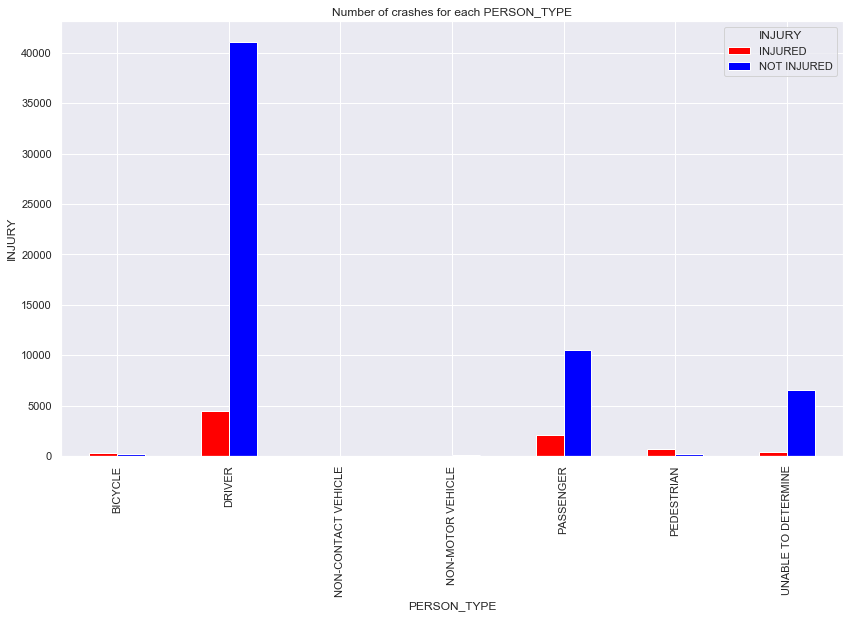

In [61]:
ax = train_new_class.groupby(['INJURY','PERSON_TYPE'])['PERSON_TYPE'].count().unstack(0).plot.bar(title="Number of crashes for each PERSON_TYPE", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('PERSON_TYPE')
_ = ax.set_ylabel('INJURY')

In [62]:
train_new_class.groupby(['FIRST_CRASH_TYPE']).size()

FIRST_CRASH_TYPE
ANGLE                            8081
ANIMAL                             30
FIXED OBJECT                     1822
HEAD ON                           650
OTHER NONCOLLISION                121
OTHER OBJECT                      384
OVERTURNED                         16
PARKED MOTOR VEHICLE            13982
PEDALCYCLIST                      907
PEDESTRIAN                       1600
REAR END                        16564
REAR TO FRONT                     433
REAR TO REAR                      102
REAR TO SIDE                      282
SIDESWIPE OPPOSITE DIRECTION     1020
SIDESWIPE SAME DIRECTION        10157
TRAIN                               3
TURNING                         10163
dtype: int64

In [63]:
train_new_class.groupby(['FIRST_CRASH_TYPE', 'INJURY']).size().reset_index()

,FIRST_CRASH_TYPE,INJURY,0
0,ANGLE,INJURED,1506
1,ANGLE,NOT INJURED,6575
2,ANIMAL,NOT INJURED,30
3,FIXED OBJECT,INJURED,310
4,FIXED OBJECT,NOT INJURED,1512
5,HEAD ON,INJURED,229
6,HEAD ON,NOT INJURED,421
7,OTHER NONCOLLISION,INJURED,25
8,OTHER NONCOLLISION,NOT INJURED,96
9,OTHER OBJECT,INJURED,47


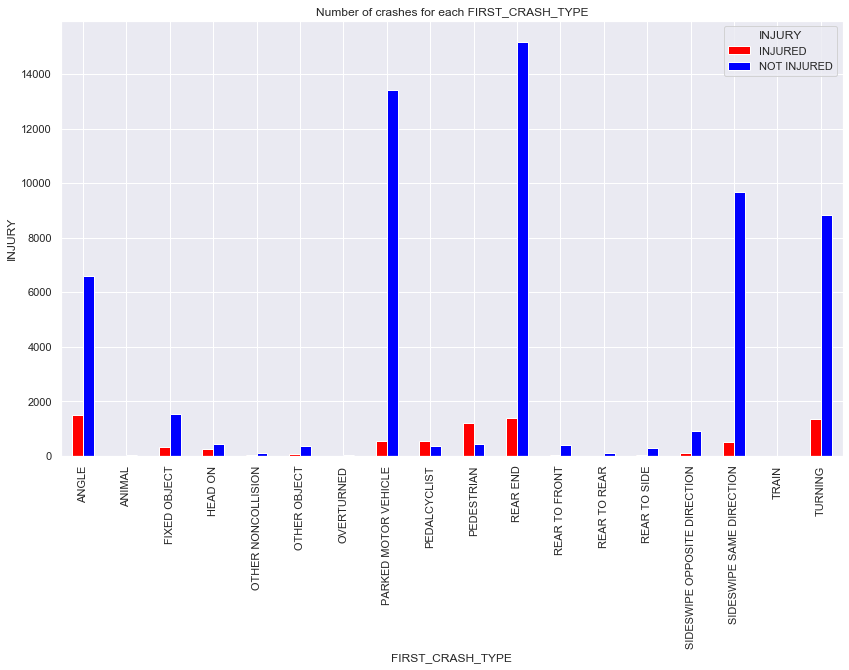

In [64]:
ax = train_new_class.groupby(['INJURY','FIRST_CRASH_TYPE'])['PERSON_TYPE'].count().unstack(0).plot.bar(title="Number of crashes for each FIRST_CRASH_TYPE", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('FIRST_CRASH_TYPE')
_ = ax.set_ylabel('INJURY')

In [180]:
train_new_class = train_new_class["FIRST_CRASH_TYPE"].drop('UNABLE TO DETERMINE')

KeyError: "['UNABLE TO DETERMINE'] not found in axis"

In [65]:
train_new_class[train_new_class["FIRST_CRASH_TYPE"] == "PEDESTRIAN"].groupby(['PRIM_CONTRIBUTORY_CAUSE'])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['count'], ascending=False)

,PRIM_CONTRIBUTORY_CAUSE,count
27,UNABLE TO DETERMINE,584
15,FAILING TO YIELD RIGHT-OF-WAY,453
22,NOT APPLICABLE,112
14,FAILING TO REDUCE SPEED TO AVOID CRASH,77
5,DISREGARDING TRAFFIC SIGNALS,61
23,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",50
29,"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...",47
18,IMPROPER BACKING,43
30,WEATHER,23
24,PHYSICAL CONDITION OF DRIVER,21


In [66]:
train_new_class.groupby(['PRIM_CONTRIBUTORY_CAUSE', 'INJURY']).size().reset_index()

,PRIM_CONTRIBUTORY_CAUSE,INJURY,0
0,ANIMAL,INJURED,16
1,ANIMAL,NOT INJURED,36
2,BICYCLE ADVANCING LEGALLY ON RED LIGHT,INJURED,3
3,BICYCLE ADVANCING LEGALLY ON RED LIGHT,NOT INJURED,8
4,CELL PHONE USE OTHER THAN TEXTING,INJURED,10
...,...,...,...
71,UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN...,NOT INJURED,310
72,"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...",INJURED,79
73,"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...",NOT INJURED,322
74,WEATHER,INJURED,118


**Code for seating position of motor vehicle occupant:**
- 1= driver, 
- 2= center front, 
- 3 = front passenger,
- 4 = second row left, 
- 5 = second row center, 
- 6 = second row right, 
- 7 = enclosed passengers, 
- 8 = exposed passengers, 
- 9= unknown position, 
- 10 = third row left, 
- 11 = third row center, 
- 12 = third row right

In [67]:
train_new_class.groupby(['SEAT_NO', 'INJURY']).size().reset_index()

,SEAT_NO,INJURY,0
0,0,INJURED,5723
1,0,NOT INJURED,48046
2,1,INJURED,35
3,1,NOT INJURED,508
4,10,INJURED,50
5,10,NOT INJURED,235
6,11,INJURED,33
7,11,NOT INJURED,97
8,12,INJURED,69
9,12,NOT INJURED,265


In [68]:
train_new_class.groupby(['SEAT_NO', 'INJURY']).size().reset_index(name='count') \
 .sort_values(['count'], ascending = False)

,SEAT_NO,INJURY,count
1,0,NOT INJURED,48046
0,0,INJURED,5723
13,3,NOT INJURED,4987
19,6,NOT INJURED,1797
15,4,NOT INJURED,1438
12,3,INJURED,967
3,1,NOT INJURED,508
17,5,NOT INJURED,504
11,2,NOT INJURED,432
18,6,INJURED,369


In [69]:
# trial 1 drop "PERSON_TYPE"
train_new_class = train_new_class.drop("PERSON_TYPE", axis=1)
# trial 2 drop "CRASH_HOUR"
train_new_class = train_new_class.drop("CRASH_HOUR", axis=1)
# trial 3 drop "PEDPEDAL_VISIBILITY"
train_new_class = train_new_class.drop("PEDPEDAL_VISIBILITY", axis=1)

In [70]:
train_new_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66317 entries, 904 to 15795
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   POSTED_SPEED_LIMIT       66317 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   66317 non-null  object 
 2   DEVICE_CONDITION         66317 non-null  object 
 3   WEATHER_CONDITION        66317 non-null  object 
 4   LIGHTING_CONDITION       66317 non-null  object 
 5   FIRST_CRASH_TYPE         66317 non-null  object 
 6   TRAFFICWAY_TYPE          66317 non-null  object 
 7   LANE_CNT                 66317 non-null  int64  
 8   ALIGNMENT                66317 non-null  object 
 9   ROADWAY_SURFACE_COND     66317 non-null  object 
 10  ROAD_DEFECT              66317 non-null  object 
 11  INTERSECTION_RELATED_I   66317 non-null  object 
 12  NOT_RIGHT_OF_WAY_I       66317 non-null  object 
 13  HIT_AND_RUN_I            66317 non-null  object 
 14  PRIM_CONTRIBUTORY_CA

# Modeling

## Decision Tree

In [71]:
# splitting the dataset into x_train and y_train
X_train = train_new_class.drop(["INJURY"],axis=1)
y_train = train_new_class["INJURY"]

In [72]:
#X_train.info()

In [73]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [74]:
X_train.head()

,POSTED_SPEED_LIMIT,LANE_CNT,NUM_UNITS,OCCUPANT_CNT,AGE,VEHICLE_AGE,TRAFFIC_CONTROL_DEVICE_SIGN,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_OTHER,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL,WEATHER_CONDITION_BLOWING SNOW,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_CLOUDY/OVERCAST,WEATHER_CONDITION_FOG/SMOKE/HAZE,WEATHER_CONDITION_FREEZING RAIN/DRIZZLE,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN,WEATHER_CONDITION_SEVERE CROSS WIND GATE,WEATHER_CONDITION_SLEET/HAIL,WEATHER_CONDITION_SNOW,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,FIRST_CRASH_TYPE_HEAD ON,FIRST_CRASH_TYPE_OTHER NONCOLLISION,FIRST_CRASH_TYPE_OTHER OBJECT,FIRST_CRASH_TYPE_OVERTURNED,FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE,FIRST_CRASH_TYPE_PEDALCYCLIST,FIRST_CRASH_TYPE_PEDESTRIAN,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO FRONT,FIRST_CRASH_TYPE_REAR TO REAR,FIRST_CRASH_TYPE_REAR TO SIDE,FIRST_CRASH_TYPE_SIDESWIPE OPPOSITE DIRECTION,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,TRAFFICWAY_TYPE_CENTER TURN LANE,TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN (NOT RAISED),TRAFFICWAY_TYPE_DIVIDED - W/MEDIAN BARRIER,TRAFFICWAY_TYPE_DRIVEWAY,"TRAFFICWAY_TYPE_FIVE POINT, OR MORE",TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_L-INTERSECTION,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_NOT REPORTED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_OTHER,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_RAMP,TRAFFICWAY_TYPE_ROUNDABOUT,TRAFFICWAY_TYPE_T-INTERSECTION,TRAFFICWAY_TYPE_TRAFFIC ROUTE,TRAFFICWAY_TYPE_UNKNOWN INTERSECTION TYPE,TRAFFICWAY_TYPE_Y-INTERSECTION,ALIGNMENT_CURVE ON HILLCREST,"ALIGNMENT_CURVE, LEVEL",ALIGNMENT_STRAIGHT AND LEVEL,ALIGNMENT_STRAIGHT ON GRADE,ALIGNMENT_STRAIGHT ON HILLCREST,ROADWAY_SURFACE_COND_ICE,ROADWAY_SURFACE_COND_NO DEFECTS,ROADWAY_SURFACE_COND_OTHER,"ROADWAY_SURFACE_COND_SAND, MUD, DIRT",ROADWAY_SURFACE_COND_SNOW OR SLUSH,ROADWAY_SURFACE_COND_WET,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_WORN SURFACE,INTERSECTION_RELATED_I_Y,NOT_RIGHT_OF_WAY_I_Y,HIT_AND_RUN_I_Y,PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_CELL PHONE USE OTHER THAN TEXTING,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING OTHER TRAFFIC SIGNS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING ROAD MARKINGS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING STOP SIGN,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS,PRIM_CONTRIBUTORY_CAUSE_DISREGARDING YIELD SIGN,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM INSIDE VEHICLE,PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - FROM OUTSIDE VEHICLE,"PRIM_CONTRIBUTORY_CAUSE_DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)",PRIM_CONTRIBUTORY_CAUSE_DRIVING ON WRONG SIDE/WRONG WAY,PRIM_CONTRIBUTORY_CAUSE_DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,PRIM_CONTRIBUTORY_CAUSE_EQUIPMENT - VEHICLE CONDITION,"PRIM_CONTRIBUTORY_CAUSE_EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST",PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT,PRIM_CONTRIBUTORY_CAUSE_EXCEEDING SAFE SPEED FOR CONDITIONS,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT,PRIM_CONTRIBUTORY_CAUSE_NOT APPLICABLE,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL

In [75]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [76]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(random_state=0, max_depth=10)


In [77]:
#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(dt_default, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9056199691460511 [0.90681544 0.90493064 0.90530046 0.90379251 0.9072608 ]


In [78]:
recall = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9796291114235316 [0.98326646 0.97763169 0.97797319 0.9803637  0.97891052]
Precision 0.9188681107619866 [0.91717767 0.91975904 0.91985867 0.91651369 0.92103149]
F1 0.9482730672852101 [0.94907293 0.94781277 0.94802615 0.94736408 0.9490894 ]


[1.81342949e-02 4.02786846e-03 7.60540220e-02 4.01780811e-02
 1.24439087e-02 6.52930903e-03 3.31557014e-04 8.31216523e-03
 1.10200267e-03 5.73040773e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.26523758e-03
 0.00000000e+00 0.00000000e+00 4.98858809e-04 1.09419373e-03
 6.93712682e-04 2.51762207e-03 1.57196451e-03 0.00000000e+00
 7.87243157e-03 1.62562785e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.13387778e-03 1.01343366e-01 2.85206676e-01
 1.01611666e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.38337140e-03 0.00000000e+00 1.24310826e-03
 2.60679213e-03 4.16595571e-03 7.37730477e-04 0.00000000e+00
 0.00000000e+00 5.93202022e-03 0.00000000e+00 3.31355991e-03
 0.00000000e+00 1.12784255e-03 0.00000000e+00 1.97337094e-03
 0.00000000e+00 0.00000000e+00 9.81109068e-04 6.58517327e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.02627627e-03 2.444181

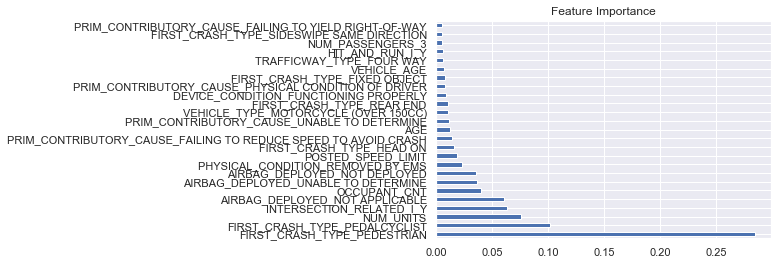

In [129]:
dt_default.fit(X_train,y_train)
print(dt_default.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(dt_default.feature_importances_, index=X_train.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [156]:
for importance, name in sorted(zip(dt_default.feature_importances_, X_train.columns),reverse=True)[:]:
    print (name, importance)

FIRST_CRASH_TYPE_PEDESTRIAN 0.28520667649037507
FIRST_CRASH_TYPE_PEDALCYCLIST 0.10134336620883234
NUM_UNITS 0.07605402200771896
INTERSECTION_RELATED_I_Y 0.06291713178552998
AIRBAG_DEPLOYED_NOT APPLICABLE 0.060101787767949603
OCCUPANT_CNT 0.04017808109499562
AIRBAG_DEPLOYED_UNABLE TO DETERMINE 0.03610177618435339
AIRBAG_DEPLOYED_NOT DEPLOYED 0.03511801450276114
PHYSICAL_CONDITION_REMOVED BY EMS 0.02270599285265274
POSTED_SPEED_LIMIT 0.018134294907976085
FIRST_CRASH_TYPE_HEAD ON 0.01625627846166221
PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH 0.013668112223051764
AGE 0.012443908730060075
PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE 0.011626002877889214
VEHICLE_TYPE_MOTORCYCLE (OVER 150CC) 0.010440602812506902
FIRST_CRASH_TYPE_REAR END 0.01016116662495514
DEVICE_CONDITION_FUNCTIONING PROPERLY 0.008312165226768522
PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER 0.008069778303708005
FIRST_CRASH_TYPE_FIXED OBJECT 0.007872431569375414
VEHICLE_AGE 0.006529309029622598
TRA

In [178]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, dt_default.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
Gini_importance = importances.sort_values(by=['Gini-importance'], ascending=False)
Gini_importance[Gini_importance['Gini-importance'] > 0]


,Gini-importance
FIRST_CRASH_TYPE_PEDESTRIAN,0.285207
FIRST_CRASH_TYPE_PEDALCYCLIST,0.101343
NUM_UNITS,0.076054
INTERSECTION_RELATED_I_Y,0.062917
AIRBAG_DEPLOYED_NOT APPLICABLE,0.060102
...,...
PEDPEDAL_ACTION_ENTER FROM DRIVE/ALLEY,0.000288
DRIVER_ACTION_NONE,0.000222
PEDPEDAL_ACTION_OTHER ACTION,0.000190
SEC_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,0.000120


In [177]:
Gini_importance[Gini_importance['Gini-importance'].str.contains("PERSON_TYPE", case=False)]

AttributeError: Can only use .str accessor with string values!

In [80]:
# Importing required packages for visualization
from IPython.display import Image 
from io import StringIO
#from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
#import pydotplus

# Putting features
features = list(train_new_class.columns[1:])
features

['TRAFFIC_CONTROL_DEVICE',
 'DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE',
 'LANE_CNT',
 'ALIGNMENT',
 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT',
 'INTERSECTION_RELATED_I',
 'NOT_RIGHT_OF_WAY_I',
 'HIT_AND_RUN_I',
 'PRIM_CONTRIBUTORY_CAUSE',
 'SEC_CONTRIBUTORY_CAUSE',
 'STREET_DIRECTION',
 'DOORING_I',
 'WORK_ZONE_I',
 'NUM_UNITS',
 'NUM_PASSENGERS',
 'VEHICLE_DEFECT',
 'VEHICLE_TYPE',
 'VEHICLE_USE',
 'TRAVEL_DIRECTION',
 'MANEUVER',
 'OCCUPANT_CNT',
 'EXCEED_SPEED_LIMIT_I',
 'FIRST_CONTACT_POINT',
 'SEAT_NO',
 'SEX',
 'AGE',
 'SAFETY_EQUIPMENT',
 'AIRBAG_DEPLOYED',
 'EJECTION',
 'DRIVER_ACTION',
 'DRIVER_VISION',
 'PHYSICAL_CONDITION',
 'PEDPEDAL_ACTION',
 'BAC_RESULT VALUE',
 'CELL_PHONE_USE',
 'INJURY',
 'Location',
 'VEHICLE_AGE']

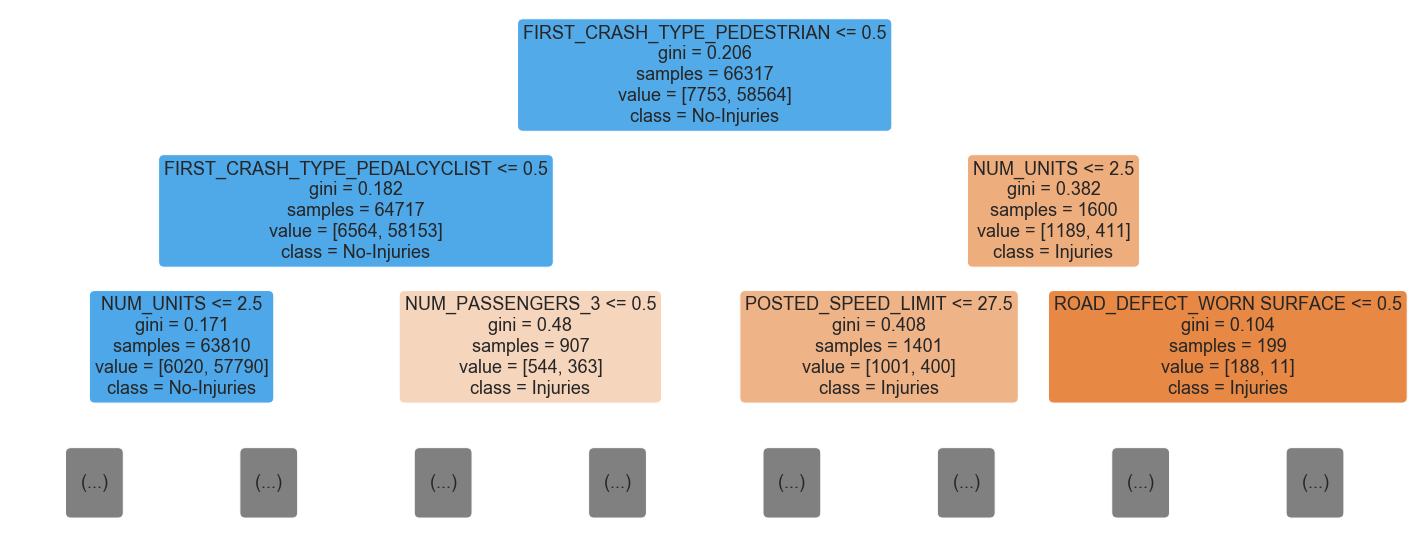

In [81]:
fn = X_train.columns.tolist()
cn = ['Injuries', 'No-Injuries']
plt.figure(figsize=(25,10))
tree_visual = tree.plot_tree(dt_default,
               feature_names = fn, 
               class_names = cn,
               max_depth = 2,
               fontsize = 18,
               rounded = True,
               filled = True)

## Logistic Regression model

In [82]:
from sklearn.linear_model import LogisticRegression

In [83]:
LR = LogisticRegression(random_state = 0)
scores = cross_val_score(LR, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9003875308810064 [0.90199035 0.89889928 0.89904245 0.90130438 0.9007012 ]


In [84]:
recall = cross_val_score(LR, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(LR, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(LR, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9794071941572555 [0.97711944 0.98010757 0.97805857 0.97942457 0.98232582]
Precision 0.9139623731965554 [0.91728781 0.91197966 0.91370234 0.91483254 0.91200951]
F1 0.9455503139477115 [0.94625878 0.94481709 0.94478578 0.9460273  0.94586262]


In [85]:
#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(LR, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9003875308810064 [0.90199035 0.89889928 0.89904245 0.90130438 0.9007012 ]


In [86]:
LR.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [124]:
print(LR.coef_)

[[-2.87834944e-02  3.35846114e-02 -6.18532978e-01  3.44888578e-02
  -2.85612423e-03 -1.93260417e-02  1.61498816e-01  2.84186008e-02
  -5.98714288e-03  5.92526298e-02  4.65991557e-02  7.49401934e-02
   1.39913073e-02 -1.02479946e-02  2.25483044e-02 -3.10905280e-02
   7.66063916e-03  1.82936514e-02  7.12110183e-02  8.12396760e-02
   5.49887548e-03 -1.84144835e-03  2.11719762e-01 -1.73398801e-01
   1.37120367e-01  1.85634253e-02  1.07559401e-01  2.64610433e-02
  -3.06833983e-01 -5.90918199e-01 -7.81859725e-02 -5.05883394e-02
  -2.37519156e-02  1.61466900e+00 -1.49599420e+00 -2.64661752e+00
   8.42853060e-01  9.20420188e-02  4.32534586e-02  1.07822377e-01
   1.66051298e-01  1.26200456e+00  3.21624585e-03  5.59868128e-01
   5.32700796e-02 -1.74066897e-01 -1.94404556e-01 -5.65757442e-02
  -7.08899004e-04 -3.09222126e-01 -7.13206643e-03 -1.16892915e-02
   3.13794644e-02  1.42356186e-01  2.33045664e-01  6.30514395e-01
   7.16123024e-02  5.06209099e-04 -1.39311723e-01 -9.44616158e-03
  -3.90777

In [116]:
X_train.columns


Index(['POSTED_SPEED_LIMIT', 'LANE_CNT', 'NUM_UNITS', 'OCCUPANT_CNT', 'AGE',
       'VEHICLE_AGE', 'TRAFFIC_CONTROL_DEVICE_SIGN',
       'DEVICE_CONDITION_FUNCTIONING PROPERLY', 'DEVICE_CONDITION_MISSING',
       'DEVICE_CONDITION_NO CONTROLS',
       ...
       'BAC_RESULT VALUE_0.2400', 'BAC_RESULT VALUE_0.2500',
       'BAC_RESULT VALUE_0.2700', 'BAC_RESULT VALUE_0.2800',
       'BAC_RESULT VALUE_0.3100', 'BAC_RESULT VALUE_0.3200',
       'BAC_RESULT VALUE_0.3500', 'CELL_PHONE_USE_UNABLE TO DETERMINE',
       'CELL_PHONE_USE_Y', 'Location_Not Downtown'],
      dtype='object', length=373)

In [147]:
# list = np.round(LR.coef_, decimals=2) >0
#plot graph of feature importances for better visualization
# feat_importance = pd.Series(LR.coef_, index=X_train.columns)
# feat_importance.nlargest(20).plot(kind='barh')
# plt.title("Feature Importance")
# plt.show()

for importance, name in sorted(zip(LR.coef_, X_train.columns),reverse=True)[:]:
    print (name, importance)

POSTED_SPEED_LIMIT [-2.87834944e-02  3.35846114e-02 -6.18532978e-01  3.44888578e-02
 -2.85612423e-03 -1.93260417e-02  1.61498816e-01  2.84186008e-02
 -5.98714288e-03  5.92526298e-02  4.65991557e-02  7.49401934e-02
  1.39913073e-02 -1.02479946e-02  2.25483044e-02 -3.10905280e-02
  7.66063916e-03  1.82936514e-02  7.12110183e-02  8.12396760e-02
  5.49887548e-03 -1.84144835e-03  2.11719762e-01 -1.73398801e-01
  1.37120367e-01  1.85634253e-02  1.07559401e-01  2.64610433e-02
 -3.06833983e-01 -5.90918199e-01 -7.81859725e-02 -5.05883394e-02
 -2.37519156e-02  1.61466900e+00 -1.49599420e+00 -2.64661752e+00
  8.42853060e-01  9.20420188e-02  4.32534586e-02  1.07822377e-01
  1.66051298e-01  1.26200456e+00  3.21624585e-03  5.59868128e-01
  5.32700796e-02 -1.74066897e-01 -1.94404556e-01 -5.65757442e-02
 -7.08899004e-04 -3.09222126e-01 -7.13206643e-03 -1.16892915e-02
  3.13794644e-02  1.42356186e-01  2.33045664e-01  6.30514395e-01
  7.16123024e-02  5.06209099e-04 -1.39311723e-01 -9.44616158e-03
 -3.90

In [110]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(LR, threshold=-np.inf, max_features=8)
smf.fit(X_train,y_train)
feature_idx=smf.get_support()
feature_name=features.columns[feature_idx]
feature_name

AttributeError: 'list' object has no attribute 'columns'

## Random Forest -Classifier (All Post-Crash Categories)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

In [ ]:
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(50)

## Random Forest - Regressor (All Post-Crash Categories)

In [ ]:
# removing below columns
drop_list=["LATITUDE","LONGITUDE","INJURY","CRASH_DATE"]

train_new_reg = train.drop(drop_list, axis=1)

In [ ]:
# splitting the dataset into x_train and y_train
X_train = train_new_reg.drop(["INJURIES_TOTAL"],axis=1)
y_train = train_new_reg["INJURIES_TOTAL"]

In [ ]:
#X_train.info()

In [ ]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [ ]:
X_train.head()

In [ ]:
#Create a Random Forest Classifier
#clf=RandomForestRegressor()

#Train the model using the training sets y_pred=clf.predict(X_test)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print('mean_squared_error', np.mean(scores), scores)

In [ ]:
#Create a Random Forest Classifier
clf=RandomForestRegressor()
clf.fit(X_train,y_train)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
feat_importances.nlargest(50)

## Decision Tree

Filtering out the most important variables identified by Random Forest

In [ ]:
train["POSTED_SPEED_LIMIT"]=pd.to_numeric(train["POSTED_SPEED_LIMIT"])

In [ ]:
filter_list=["FIRST_CRASH_TYPE","AGE","AIRBAG_DEPLOYED","INTERSECTION_RELATED_I","LANE_CNT","SEX",
             "TRAFFICWAY_TYPE","POSTED_SPEED_LIMIT","CRASH_HOUR","VEHICLE_YEAR","FIRST_CRASH_TYPE","INJURY"]

train_new = train[filter_list]

In [ ]:
#train_new["FIRST_CRASH_TYPE"].unique

In [ ]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [ ]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [ ]:
X_train

In [ ]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [ ]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=10)

In [ ]:
recall = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

### Graphviz

Python requires library pydot and an external software graphviz to visualize the decision tree. If you are on wondows, you'll need to specify the path for the pydot library to access dot file from graphviz.

Please read the downloadable instructions to install graphviz. For Mac users, one way is to:

Install the python graphviz module: pip install graphviz
Then install the Graphviz software on Mac, you do this using homebrew:
Install homebrew: https://docs.brew.sh/Installation
brew install graphviz

In [ ]:
# Importing required packages for visualization
from IPython.display import Image 
from io import StringIO
#from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
#import pydotplus

# Putting features
features = list(train_new.columns[1:])
features

In [ ]:
# dt_default.fit(X_train,y_train)
# export_graphviz(dt_default,
#                      out_file="tree.dot",
#                      filled=True,rounded=True)